# Probabilistic Generative Models: Learning the position of the object

<br>
### Ian Tsybulkin 
Bldbox co-founder
<br>
<br>

Twitter: @tsybulkin

https://www.linkedin.com/in/tsybulkin/

https://www.facebook.com/ian.tsybulkin

## Box position detection

![Conveyor](conveyor.jpg "Conveyor")

![gen](gen-images.jpeg "Approach")

## The problem:

### Input:
- the boxes dimensions
- the camera shot
- camera parameters defined by the matrix M

### To find:
- the box coordinates x, y
- the box angle a
- the box type


In [1]:
from IPython.display import Latex
import numpy as np
from PIL import Image
from PIL import ImageDraw
# import matplotlib
# matplotlib.use("Agg")
from matplotlib import pyplot as plt
# import matplotlib.animation as manimation

## Camera setup

![Cam](cam.jpeg "Camera setup")

In [2]:
# Let us define intrinsic camera matrix and camera location

K = np.array([[600., 0., 300.],
              [0., 600., 200.],
              [0.,   0., 1.]])

cam_xyz = np.array([[0, -1., 1.5]]).T

In [3]:
# let us find extrinsic camera matrix

def get_zxz(a, b, g):
    """returns rotation matrix according to ZXZ euler schema
    """
    c1, s1 = np.cos(a), np.sin(a)
    c2, s2 = np.cos(b), np.sin(b)
    c3, s3 = np.cos(g), np.sin(g)

    return np.array([
        [c1*c3-c2*s1*s3,-c1*s3-c2*c3*s1, s1*s2],
        [c3*s1+c1*c2*s3, c1*c2*c3-s1*s3,-c1*s2],
        [s2*s3,          c3*s2,          c2]
        ])

In [4]:
R = get_zxz(0, -np.pi/2 -np.pi/3, 0)
T = -R.T.dot(cam_xyz)
RT = np.hstack([ R.transpose(), T])
RT
M = K.dot(RT)

## 3D / 2D Transformation Matrix



<br>
<br>

\begin{bmatrix}
    600 & 150 & -260 & 540 \\
    0   &-420 & -473 & 290 \\
    0   & 0.5 & -0.8 & 1.7
\end{bmatrix}



$$
uv = M \cdot XYZ
$$

$$
uv =
\begin{bmatrix}
    u \\ v \\ w 
\end{bmatrix}
$$

$$
XYZ =
\begin{bmatrix}
    X \\ Y \\ Z \\ 1 
\end{bmatrix}
$$

In [5]:
# Let us check where comes global origin in the image

X,Y,Z = (0, 0, 0)
u,v,w = M.dot(np.array([X, Y, Z, 1]))
u/w, v/w

(300.0, 161.30418691466295)

In [6]:
def rotate(p, angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([ [c,-s, 0],
                      [s, c, 0],
                      [0, 0, 1]]).dot(p)

## Box model

Width x Depth x Height

In [7]:
# dimensions 60cm x 40cm x 30cm

Dims = [np.array([0.6, 0.4, 0.3]), 
        np.array([0.4, 0.4, 0.35]), 
        np.array([0.4, 0.3, 0.2])]

In [8]:
def poly_list(x, y, a, ix):
    dx, dy, z = Dims[int(ix)] / 2
    top = [ np.array([-dx,-dy, 2*z]),
            np.array([ dx,-dy, 2*z]),
            np.array([ dx, dy, 2*z]),
            np.array([-dx, dy, 2*z]) ]
    top = [ rotate(p, a) for p in top ]
    t = np.array([x, y, 0])
    top = [p + t for p in top]
    Ls = [top]
    for i in range(4):
        Ls.append([top[i], top[i-1], top[i-1]-np.array([0,0,2*z]), top[i]-np.array([0,0,2*z])])
    return Ls


In [9]:
# generating image
def gen_img(dx, dy, a, ix):
    polygons = [[ M.dot(np.array([x,y,z,1])) for x,y,z in poly] for poly in poly_list(dx, dy, a, ix)]
    pix = [[(u/w, v/w) for u,v,w in poly] for poly in polygons]
    
    im = Image.new('L', (600,400), 0)
    draw = ImageDraw.Draw(im)
    [draw.polygon(shape,fill=255) for shape in pix]
    
    return im
    

## 'Real' cam shot

Let us define hidden parameters of our box - its type, position, and its angle:

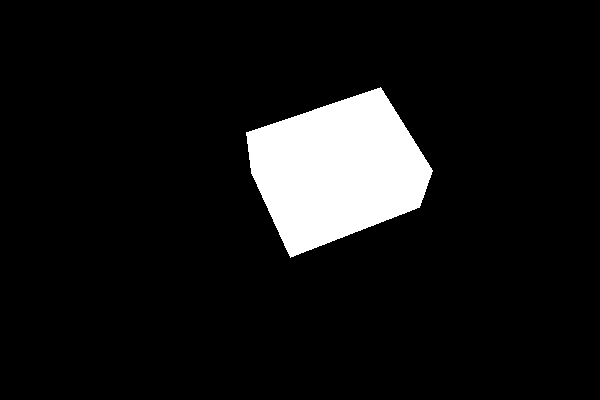

In [10]:
BoxType = 2
Angle = 0.4
X = 0.1
Y = -0.1
cam_shot = gen_img(X,Y,Angle,BoxType)
cam_shot


## Generative algorithm


![State](state.jpeg "State")

## Loss function


In [11]:
CAM_ARR = (np.array(cam_shot) > 100)
WEIGHT = CAM_ARR.sum()

def loss(gen_im):
    return (np.logical_xor(CAM_ARR, (np.array(gen_im, dtype='uint8') > 100)).astype('int')).sum()

19845 pixels do not match


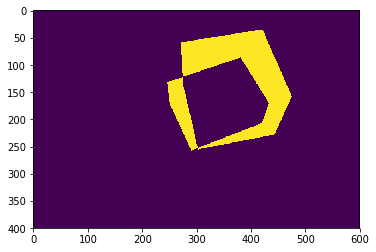

In [12]:
init = np.array([np.random.normal(scale=0.1), 
                 np.random.normal(scale=0.1), 
                 np.random.uniform(-np.pi/2, np.pi/2),
                 np.random.choice(len(Dims))])
val = loss(gen_img(*init))
print "%i pixels do not match" % val
plt.figure(figsize=(6,4))
plt.imshow(np.logical_xor(CAM_ARR, (np.array(gen_img(*init),dtype='uint8')>100)).astype('int'))
plt.show()

## Transition probabilities
<br>

$S_i = \{x_i, y_i, a_i, t_i\}, \space  V_i = Loss(S_i) $

$S_{i+1} = \{x_{i+1}, y_{i+1}, a_{i+1}, t_{i+1}\}, \space  V_{i+1} = Loss(S_{i+1}) $

<br>

$p = e^{ -50 \cdot \frac{V_{i+1} - V_i}{V_i}}  $

<br>

It means that if the the new value of the loss function is 5% higher, the probability to come to the new state will be only 8%. However, if the new value is merely 3% higher than the old one, the probability of the transition is 22%.



![Markovian process](hmm.jpeg "Generative process")

In [13]:
def accepted(New, Old):
    v = -(New - Old)/Old * 30
    if v >= 0: return True
    return np.exp(v) > np.random.random()

In [14]:
curr = init.copy()
curr_val = val.copy()
history = [(val, curr)]
rejected = 0
i = 0
while curr_val > 50 and i < 1000:
    i += 1
    dx, dy, da = np.random.normal(scale=(0.005, 0.005, 0.1), size=3)
    dix = np.random.choice([-1,0,1], p=[0.1, 0.8, 0.1])
    new = curr + np.array([dx, dy, da, dix])
    if new[3] >= len(Dims): new[3] = len(Dims) - 1
    elif new[3] < 0: new[3] = 0
        
    if abs(new[0]) > 0.3 or abs(new[1]) > 0.2 or rejected > 20:
        curr = np.array([np.random.normal(scale=0.1), 
                         np.random.normal(scale=0.1), 
                         np.random.uniform(-np.pi/2, np.pi/2),
                         np.random.choice(len(Dims))
                        ])
        curr_val = loss(gen_img(*curr))
        rejected = 0
        continue
    new_val = loss(gen_img(*new))
    
    if accepted(new_val, curr_val):
        curr_val = new_val
        curr = new.copy()
        history.append((curr_val, curr.copy()))
        rejected = 0
    else:
        rejected += 1
print "%i iteration done" % i, 

1000 iteration done


In [15]:
v, best = min(history, key=lambda x: x[0])
print "Image match: %.1f%%" % ((100*(1-float(v)/WEIGHT)))

Image match: 99.2%


In [16]:
best

array([ 0.0987453 , -0.10063054,  0.40347114,  2.        ])

## Loss decrease through iterations

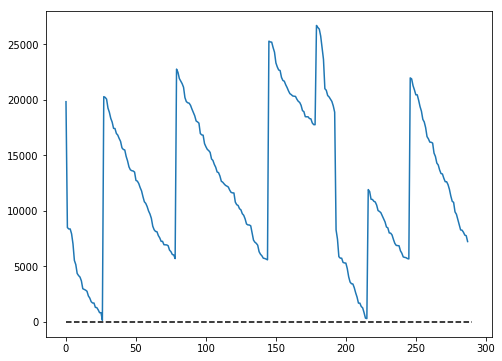

In [17]:
vals,_ = zip(*history)
plt.figure(figsize=(8,6))
plt.plot(vals)
plt.plot([0,len(history)+2],[0,0], '--k')
plt.show()

In [18]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,3,1)
plt.imshow(gen_img(*best))
ax1.title.set_text("Learned")

ax2 = plt.subplot(1,3,2)
plt.imshow(cam_shot)
ax2.title.set_text("Original")

ax3 = plt.subplot(1,3,3)
plt.imshow((CAM_ARR - np.array(gen_img(*best))).astype('int8'))
plt.imshow(np.logical_xor(CAM_ARR, (np.array(gen_img(*best),
                        dtype='uint8')>100)).astype('float'))
ax3.title.set_text("Error")

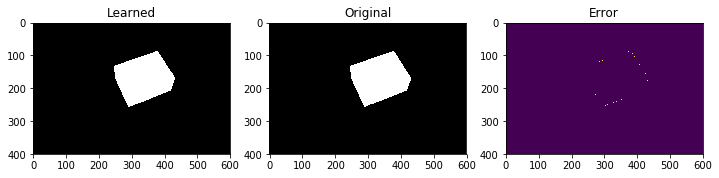


XY error:   -1 x 0 mm
Angle error: 0.2 degrees
Box type:    correct


In [19]:

plt.show()

error = best - np.array([X,Y,Angle,BoxType])
print "\nXY error:   %i x %i mm" % tuple(error[:2]*1000)
print "Angle error: %.1f degrees" % np.degrees(error[2])
print "Box type:    %s" % ("correct" if error[3]==0 else "incorrect") 